# Проект: Создание модели машинного обучения, которая спрогнозирует количество заказов такси на следующий час

## Введение

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час.

Значение метрики RMSE на тестовой выборке должно быть не больше 48.

### Цель исследования

1. Построить модель, прогнозирующую количество заказов такси на следующий час

### Ход исследования

1. Загрузка данных, выполнение ресемплирования по одному часу;
2. Анализ данных;
3. Обучение моделей с различными гиперпараметрами;
4. Проверка данных на тестовой выборке.

## Загрузка данных

In [ ]:
'''try:
  from google.colab import drive
  drive.mount('/content/drive')
except:
  print('Google Drive не установлен.')'''

"try:\n  from google.colab import drive\n  drive.mount('/content/drive')\nexcept:\n  print('Google Drive не установлен.')"

In [2]:
!pip install --upgrade scikit-learn -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.5/13.5 MB 81.5 MB/s eta 0:00:00


In [3]:
!pip install lightgbm -q

In [4]:
!pip install catboost -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 7.2 MB/s eta 0:00:00


In [5]:
import sys
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.model_selection import (
    train_test_split,
    cross_val_score,
    GridSearchCV,
    RandomizedSearchCV,
    TimeSeriesSplit
    )
from sklearn.preprocessing import (
    OneHotEncoder,
    OrdinalEncoder,
    StandardScaler,
    MinMaxScaler
    )
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error #root_mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.dummy import DummyRegressor
from statsmodels.tsa.seasonal import seasonal_decompose

from catboost import CatBoostRegressor
import lightgbm as lgb

/usr/local/lib/python3.11/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [6]:
# объявление констант
RANDOM_STATE = 42
TEST_SIZE = 0.10

In [7]:
# загрузка данных
dataset_url = 'https://code.s3.yandex.net/datasets/taxi.csv'
taxi = pd.read_csv(dataset_url, index_col=[0], parse_dates=[0])

In [8]:
'''# загрузка данных

# Определяем, где мы находимся
if 'google.colab' in sys.modules:
    # Google Colab
    dataset_url = '/content/drive/MyDrive/Colab Notebooks/11. Time series/datasets/taxi.csv'
else:
    # локальная среда (Jupyter)
    dataset_url = '/datasets/taxi.csv'

taxi = pd.read_csv(dataset_url, index_col=[0], parse_dates=[0])'''

"# загрузка данных\n\n# Определяем, где мы находимся\nif 'google.colab' in sys.modules:\n    # Google Colab\n    dataset_url = '/content/drive/MyDrive/Colab Notebooks/11. Time series/datasets/taxi.csv'\nelse:\n    # локальная среда (Jupyter)\n    dataset_url = '/datasets/taxi.csv'\n\ntaxi = pd.read_csv(dataset_url, index_col=[0], parse_dates=[0])"

In [9]:
# общий взгляд на данные
taxi.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [10]:
# просмотр краткого содержания данных
taxi.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


### Предобработка данных

Не требуется

### Исследовательский анализ данных

In [11]:
taxi.describe()

,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,119.000000


In [12]:
# проверим, в хронологическом ли порядке указаны даты и время
taxi.index.is_monotonic_increasing # is_monotonic отказывался работать в Colab

True

In [13]:
# ресемплирование (по часу)
taxi = taxi.resample('1H').sum()

<ipython-input-13-1ac904ea41a4>:2: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  taxi = taxi.resample('1H').sum()


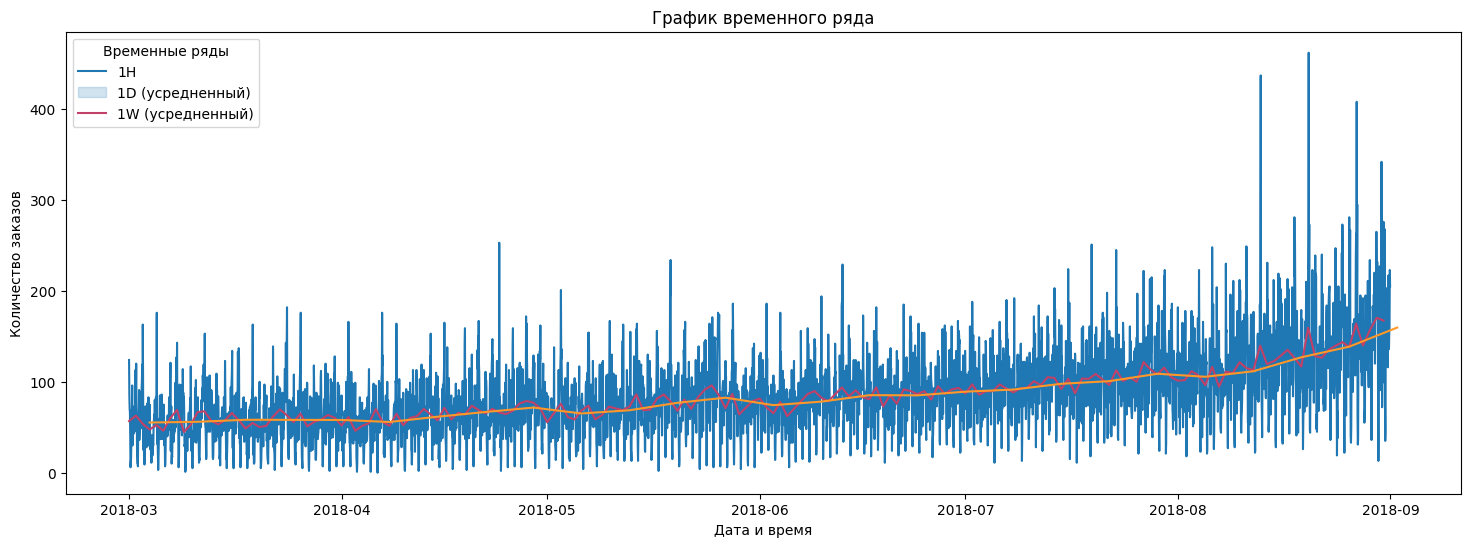

In [14]:
# график временного ряда

plt.figure(figsize=(18, 6))
sns.lineplot(data=taxi, legend=False)
sns.lineplot(data=taxi.resample('1D').mean(), palette='flare', legend=False)
sns.lineplot(data=taxi.resample('1W').mean(), palette='YlOrBr', legend=False)
plt.title(f'График временного ряда')
plt.xlabel('Дата и время')
plt.ylabel('Количество заказов')
plt.legend(
    title='Временные ряды',
    loc='upper left',
    labels=['1H', '1D (усредненный)', '1W (усредненный)']
    )

pass

Имеем данные за период 2018-03-01 - 2018-08-31

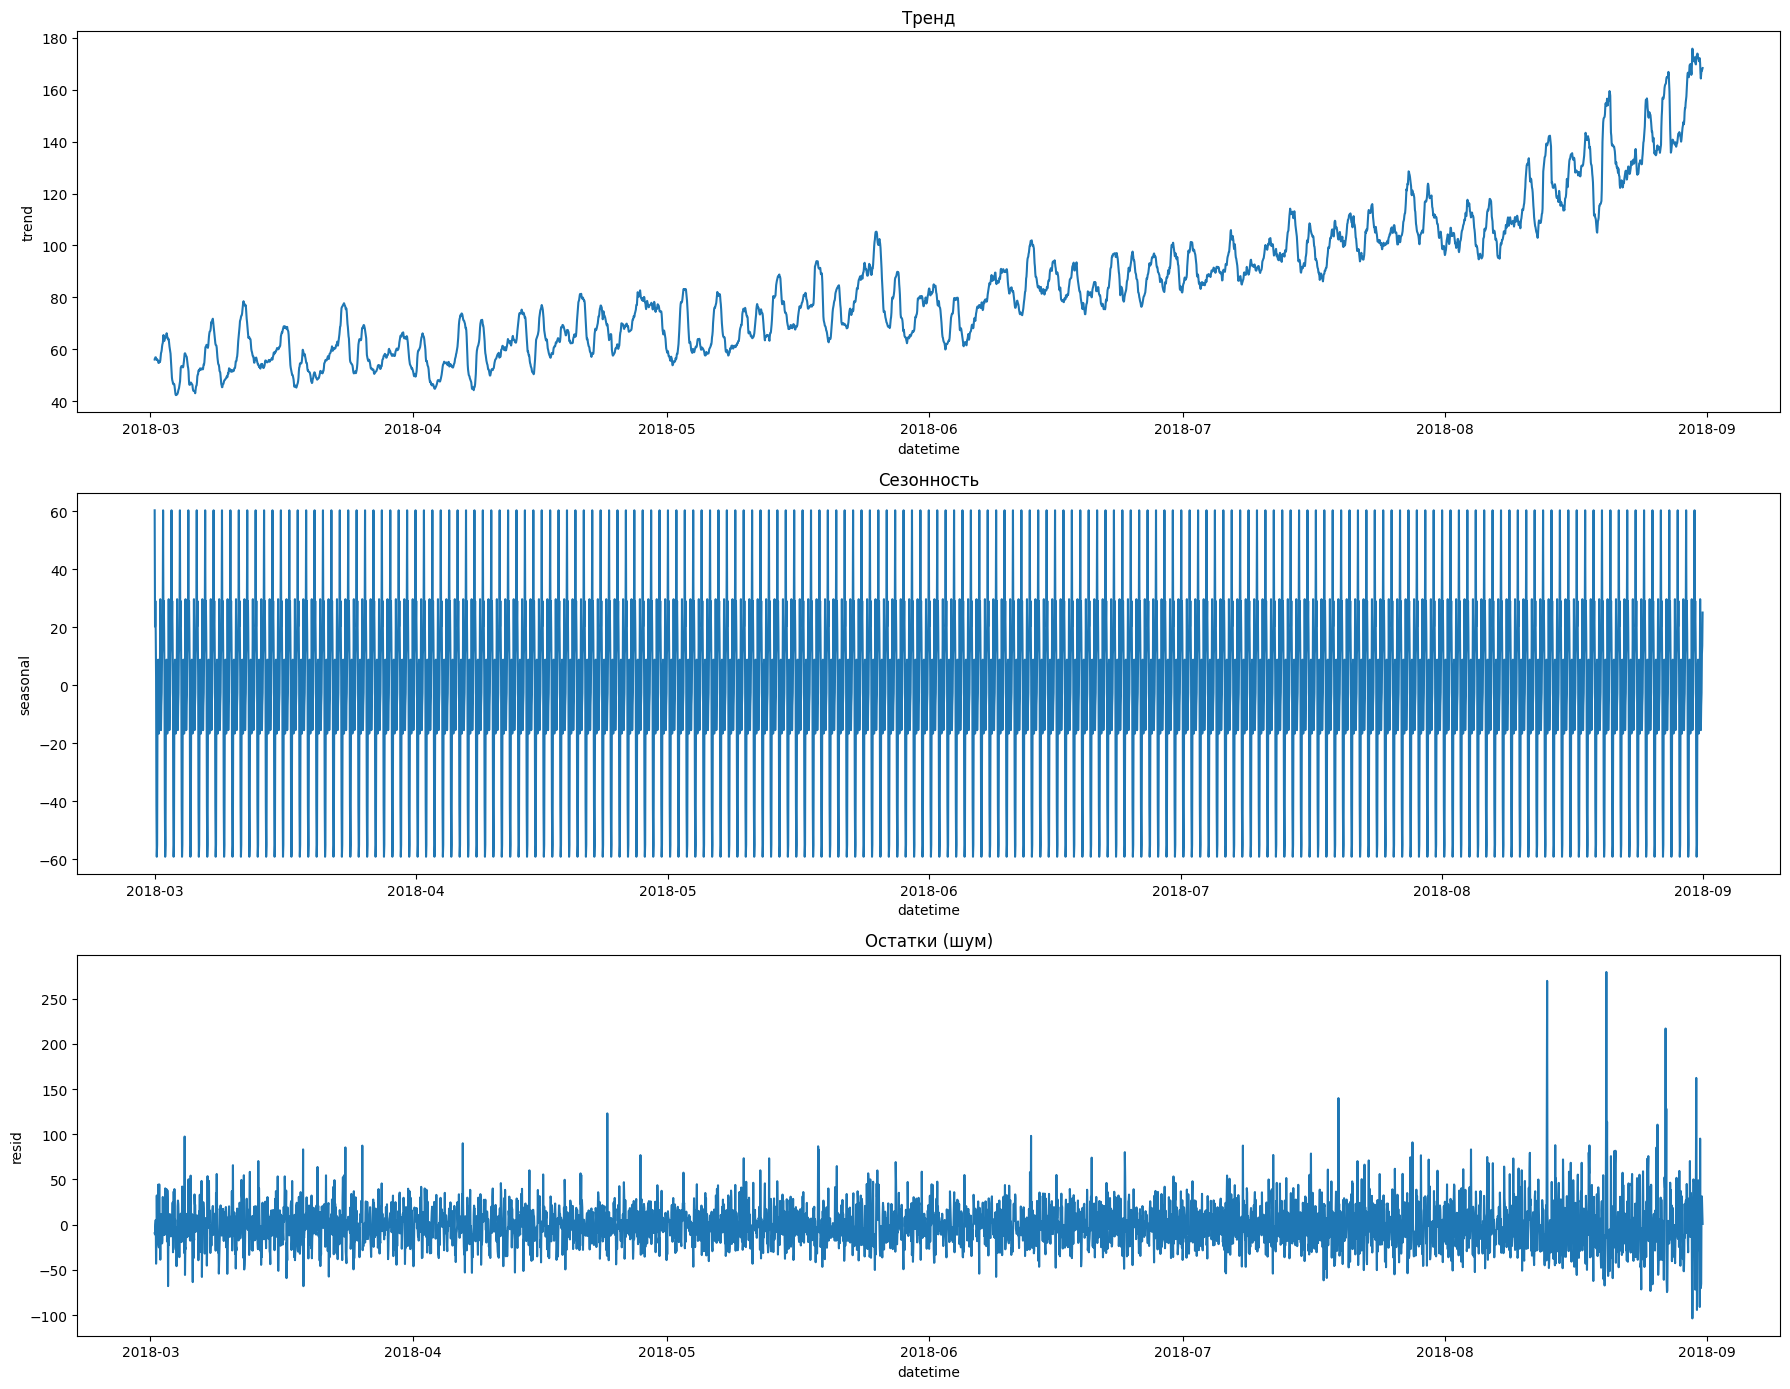

In [15]:
# разбивка на тренды, сезонность и остатки (шум)
decomposed = seasonal_decompose(taxi)

plt.figure(figsize=(18, 14))
plt.subplot(311)
sns.lineplot(data=decomposed.trend)
plt.title('Тренд')
plt.subplot(312)
sns.lineplot(data=decomposed.seasonal)
plt.title('Сезонность')
plt.subplot(313)
sns.lineplot(data=decomposed.resid)
plt.title('Остатки (шум)')
plt.tight_layout()

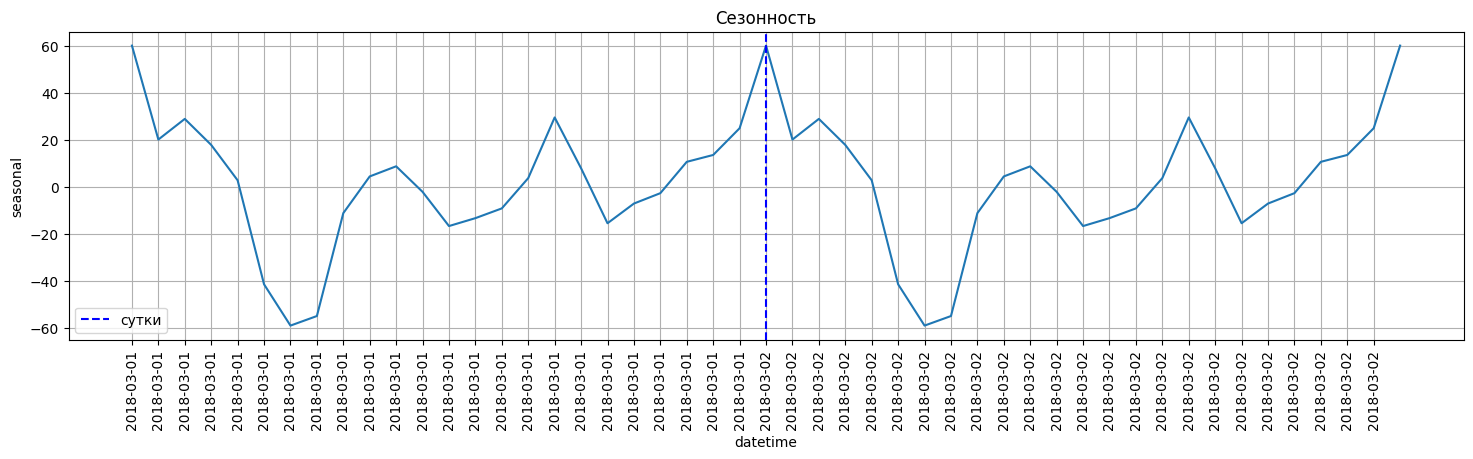

In [16]:
# сезонность: изменение количества заказов в течение дня
plt.figure(figsize=(18, 4))
sns.lineplot(
    data=decomposed.seasonal['2018-03-01 00:00:00' : '2018-03-03 00:00:00']
    )
plt.axvline(
    x=taxi.index.to_list()[24], color='b', linestyle='--', label='сутки'
    )
plt.title('Сезонность')
plt.xticks(taxi.index.to_list()[: 24*2], rotation=90)
plt.grid()
plt.legend()

pass

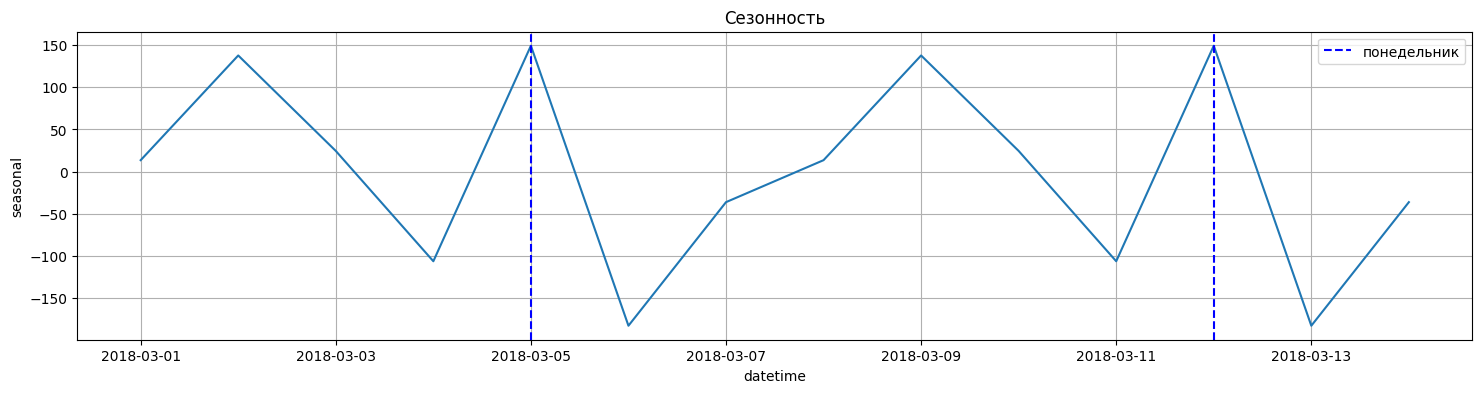

In [17]:
# сезонность: изменение количества заказов в течение недели
decomposed_day = seasonal_decompose(taxi.resample('1D').sum())
plt.figure(figsize=(18, 4))
sns.lineplot(data=decomposed_day.seasonal['2018-03-01' : '2018-03-14'])
plt.axvline (
    x=taxi.resample('1D').sum().index.to_list()[4],
    color='b',
    linestyle='--',
    label='понедельник'
    )
plt.axvline (
    x=taxi.resample('1D').sum().index.to_list()[11],
    color='b',
    linestyle='--'
    )
plt.title('Сезонность')
plt.grid()
plt.legend()

pass

### Выводы

Минимальное число заказов: 0, максимальное: 77<br>
На графиках виден  тренд на рост числа заказов, который ускоряется после 2018-08. <br>
В течение дня: дно спроса в 6 часов утра, пик - в 12 ночи.<br>
В течение недели: в понедельник и пятницу - максимум заказов, во вторник - минимум<br>
В течение месяца: недостаточно данных (в датасете всего 6 месяцев)<br>
В конце временного ряда в остатках видны резкие скачки.

## Подготовка данных

In [18]:
# создание функции, которая добавляет признаки (горизонт планирования: 1 шаг)
# признак 'месяц' создавать не будем, т.к. в данных отображено всего лишь 6 мес.
def make_features(data, max_lag, rolling_mean_size):
    data['hour'] = data.index.hour.astype('category')
    data['dayofweek'] = data.index.dayofweek.astype('category')

    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = \
    data['num_orders'].shift().rolling(rolling_mean_size).mean()

In [19]:
# копия DataFrame
taxi_new = taxi.copy()

In [20]:
# создание конкретных признаков
make_features(taxi_new, 24, 24)
taxi_new.head(7)

,num_orders,hour,dayofweek,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,...,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,0,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,1,3,124.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,2,3,85.0,124.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,3,3,71.0,85.0,124.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,43,4,3,66.0,71.0,85.0,124.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 05:00:00,6,5,3,43.0,66.0,71.0,85.0,124.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 06:00:00,12,6,3,6.0,43.0,66.0,71.0,85.0,124.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [21]:
# удаление пустых признаков
taxi_new.dropna(inplace=True)
# разбивка на тренировочную и тестовую выборки
X = taxi_new.drop(columns='num_orders')
y = taxi_new['num_orders']

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    shuffle=False,
    test_size=TEST_SIZE,
    # random_state=RANDOM_STATE
    )

display(X_train.shape)
display(y_train.shape)
display(X_test.shape)
display(y_test.shape)

(3952, 27)

(3952,)

(440, 27)

(440,)

Примечание к ячейке ниже.<br>
При попытке закодировать занчения day, month, hour, dayofweek кодировщиком OHE метрика RMSE в линейной регрессии выдает неадекватные значения. Решил его не использовать.

In [22]:
# создаём списки с названиями признаков
# OrdinalEncoder не требуется, т.к. значения вновь созданных признаков 'hour', 'dayofweek' уже идут 'по порядку'
ohe_columns = X.select_dtypes(include='category').columns.to_list()
num_columns = X.select_dtypes(exclude='category').columns.to_list()

In [23]:
# пайплайн для подготовки признаков из ohe_columns: заполнение пропусков и OHE-кодирование
ohe_pipe = Pipeline(
    [
     ('simpleImputer_ohe', SimpleImputer(
         missing_values=np.nan, strategy='most_frequent'
         )),
     ('ohe', OneHotEncoder(
         drop='first', handle_unknown='error', sparse_output=False
         ))
    ]
)

In [24]:
# создаём общий пайплайн для подготовки данных
data_preprocessor = ColumnTransformer(
    [('ohe', ohe_pipe, ohe_columns),
     ('num', StandardScaler(), num_columns)
    ],
    #remainder='passthrough'
)

In [25]:
# создаём итоговый пайплайн: подготовка данных и модель
pipe_final = Pipeline(
    [
    ('preprocessor', data_preprocessor),
    ('models', LinearRegression())
    ]
)

In [26]:
param_grid_cb = [
    # словарь для модели CatBoostRegressor()
    {
        'models':[CatBoostRegressor(random_state=RANDOM_STATE, cat_features=[])],
        'models__n_estimators': [250, 500], #кол-во деревьев в град. бустинге
        'models__max_depth': [i for i in range(6, 24, 6)], # max глубина дерева
        'preprocessor__num': ['passthrough']
    }
]
param_grid_lgbmr = [

    # словарь для модели LGBMRRegressor()
    {
        'models': [lgb.LGBMRegressor(random_state=RANDOM_STATE)],
        'models__n_estimators': [250, 500], #кол-во деревьев в град. бустинге
        'models__max_depth': [i for i in range(6, 26, 6)], # max глубина дерева
        'preprocessor__num': ['passthrough']
    }
]
param_grid_dtr = [
    # словарь для модели DecisionTreeRegressor()
    {
        'models': [DecisionTreeRegressor(random_state=RANDOM_STATE)],
        'models__max_depth': [i for i in range(6, 24, 6)],
        'preprocessor__num': ['passthrough']
    }
]
param_grid_lr = [
    # словарь для модели линейной регрессии
    {
        'models': [LinearRegression()],
        'preprocessor__num': [
            OneHotEncoder(), StandardScaler(), MinMaxScaler(), 'passthrough'
            ]
    }
]

### Выводы

Данные подготовлены для дальнейшего моделирования

## Обучение моделей

### Модель 1: LinearRegression

In [ ]:
# обучение модели с помощью TimeSeriesSplit (кросс-валидатор для времен. рядов)
tscv = TimeSeriesSplit(n_splits=5)
# model_lr  = LinearRegression()

grid_search_lr = GridSearchCV(
    estimator=pipe_final,
    param_grid=param_grid_lr,
    cv=tscv,
    scoring='neg_root_mean_squared_error', # root_mean_squared_error не работает
    n_jobs=-1
)
grid_search_lr.fit(X_train, y_train)
print (
    'Метрика RMSE модели при кросс-валидации:',
    grid_search_lr.best_score_ * (-1)
    )

/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 279, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 371, in _score
    y_pred = method_caller(
  File "/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 89, in _cached_call
    result, _ = _get_response_values(
  File "/opt/conda/lib/python3.9/site-packages/sklearn/utils/_response.py", line 239, in _get_response_values
    y_pred, pos_label = prediction_m

Метрика RMSE модели при кросс-валидации: 25.42749204548963


/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_search.py:1103: UserWarning: One or more of the test scores are non-finite: [         nan -25.43467601 -25.42901392 -25.42749205]
  warnings.warn(


### Модель 2: CatBoostRegressor

In [ ]:
# подбор гиперпараметров
model_cb = CatBoostRegressor(random_state=RANDOM_STATE, cat_features=[])

grid_search_cb = GridSearchCV(
    estimator=pipe_final,
    param_grid=param_grid_cb,
    cv=tscv,
    scoring='neg_root_mean_squared_error', # root_mean_squared_error не работает
    n_jobs=-1,
    verbose=2
)
grid_search_cb.fit(X_train, y_train)

print(
    'Модель с лучшими гиперпараметрами и её параметры:\n\n',
    grid_search_cb.best_params_
    )
print ('Метрика модели при кросс-валидации:', grid_search_cb.best_score_ * (-1))

Fitting 5 folds for each of 6 candidates, totalling 30 fits
Learning rate set to 0.1184
0:	learn: 28.2210333	total: 5.23ms	remaining: 1.3s
1:	learn: 26.7669864	total: 8.78ms	remaining: 1.09s
2:	learn: 25.7377540	total: 12.1ms	remaining: 994ms
3:	learn: 24.6783992	total: 15.3ms	remaining: 943ms
4:	learn: 23.8243371	total: 18.4ms	remaining: 902ms
5:	learn: 23.0172224	total: 21.4ms	remaining: 871ms
6:	learn: 22.1932475	total: 24.5ms	remaining: 849ms
7:	learn: 21.6030436	total: 27.4ms	remaining: 830ms
8:	learn: 21.0076302	total: 30.4ms	remaining: 815ms
9:	learn: 20.5241836	total: 33.5ms	remaining: 803ms
10:	learn: 20.0558118	total: 36.5ms	remaining: 792ms
11:	learn: 19.6411637	total: 39.5ms	remaining: 784ms
12:	learn: 19.2210947	total: 42.7ms	remaining: 779ms
13:	learn: 18.8977775	total: 45.7ms	remaining: 771ms
14:	learn: 18.6116536	total: 48.8ms	remaining: 765ms
15:	learn: 18.3284808	total: 51.8ms	remaining: 758ms
16:	learn: 18.0961167	total: 54.9ms	remaining: 752ms
17:	learn: 17.7913691	

/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
10 fits failed out of a total of 30.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/lib/python3.9/site-packages/sklearn/base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/opt/conda/lib/python3.9/site-packages/sklearn/pipeline.py", line 473, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "/opt/conda/lib/python3.

0:	learn: 37.2572029	total: 6.03ms	remaining: 3.01s
1:	learn: 35.8833654	total: 11.8ms	remaining: 2.93s
2:	learn: 34.6549649	total: 17.1ms	remaining: 2.83s
3:	learn: 33.5908488	total: 22.1ms	remaining: 2.74s
4:	learn: 32.6153686	total: 27ms	remaining: 2.67s
5:	learn: 31.6652945	total: 32.4ms	remaining: 2.66s
6:	learn: 30.8572216	total: 37.6ms	remaining: 2.65s
7:	learn: 30.1551071	total: 42.6ms	remaining: 2.62s
8:	learn: 29.5217855	total: 48.1ms	remaining: 2.62s
9:	learn: 28.9750395	total: 53.3ms	remaining: 2.61s
10:	learn: 28.4486620	total: 58.6ms	remaining: 2.6s
11:	learn: 27.9998623	total: 63.5ms	remaining: 2.58s
12:	learn: 27.6005907	total: 68.6ms	remaining: 2.57s
13:	learn: 27.2504419	total: 73.7ms	remaining: 2.56s
14:	learn: 26.8993882	total: 79ms	remaining: 2.55s
15:	learn: 26.6060389	total: 83.9ms	remaining: 2.54s
16:	learn: 26.3073164	total: 88.9ms	remaining: 2.52s
17:	learn: 26.0687687	total: 93.8ms	remaining: 2.51s
18:	learn: 25.8238655	total: 98.7ms	remaining: 2.5s
19:	learn

### Модель 3:  LGBMRegressor

In [ ]:
#  подбор гиперпараметров
model_lgbmr = lgb.LGBMRegressor(random_state=RANDOM_STATE)

grid_search_lgbmr = GridSearchCV(
    estimator=pipe_final,
    param_grid=param_grid_lgbmr,
    cv=tscv,
    scoring='neg_root_mean_squared_error', # root_mean_squared_error не работает
    n_jobs=-1,
    verbose=2
)
grid_search_lgbmr.fit(X_train, y_train)

print(
    'Модель с лучшими гиперпараметрами и её параметры:\n\n',
    grid_search_lgbmr.best_estimator_
    )
print (
    'Метрика модели при кросс-валидации:',
    grid_search_lgbmr.best_score_ * (-1)
    )

Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV] END models=LGBMRegressor(random_state=42), models__max_depth=6, models__n_estimators=250, preprocessor__num=passthrough; total time=   1.5s
[CV] END models=LGBMRegressor(random_state=42), models__max_depth=6, models__n_estimators=250, preprocessor__num=passthrough; total time=   2.1s
[CV] END models=LGBMRegressor(random_state=42), models__max_depth=6, models__n_estimators=250, preprocessor__num=passthrough; total time=   2.1s
[CV] END models=LGBMRegressor(random_state=42), models__max_depth=6, models__n_estimators=250, preprocessor__num=passthrough; total time=   2.9s
[CV] END models=LGBMRegressor(random_state=42), models__max_depth=6, models__n_estimators=250, preprocessor__num=passthrough; total time=   2.7s
[CV] END models=LGBMRegressor(random_state=42), models__max_depth=6, models__n_estimators=500, preprocessor__num=passthrough; total time=   2.9s
[CV] END models=LGBMRegressor(random_state=42), models__max_depth=6, m

### Модель 4:  DesitionTreeRegressor

In [ ]:
# подбор гиперпараметров
model_dtr = DecisionTreeRegressor(random_state=RANDOM_STATE)

grid_search_dtr = GridSearchCV(
    estimator=pipe_final,
    param_grid=param_grid_dtr,
    cv=tscv,
    scoring='neg_root_mean_squared_error', # root_mean_squared_error не работает
    n_jobs=-1,
    verbose=2
)
grid_search_dtr.fit(X_train, y_train)

print(
    'Модель с лучшими гиперпараметрами и её параметры:\n\n',
    grid_search_dtr.best_params_
    )
print (
    'Метрика RMSE модели при кросс-валидации:',
    grid_search_dtr.best_score_ * (-1)
    )

Fitting 5 folds for each of 3 candidates, totalling 15 fits
[CV] END models=DecisionTreeRegressor(random_state=42), models__max_depth=6, preprocessor__num=passthrough; total time=   0.0s
[CV] END models=DecisionTreeRegressor(random_state=42), models__max_depth=6, preprocessor__num=passthrough; total time=   0.1s
[CV] END models=DecisionTreeRegressor(random_state=42), models__max_depth=6, preprocessor__num=passthrough; total time=   0.0s
[CV] END models=DecisionTreeRegressor(random_state=42), models__max_depth=6, preprocessor__num=passthrough; total time=   0.0s
[CV] END models=DecisionTreeRegressor(random_state=42), models__max_depth=6, preprocessor__num=passthrough; total time=   0.0s
[CV] END models=DecisionTreeRegressor(random_state=42), models__max_depth=12, preprocessor__num=passthrough; total time=   0.0s
[CV] END models=DecisionTreeRegressor(random_state=42), models__max_depth=12, preprocessor__num=passthrough; total time=   0.0s
[CV] END models=DecisionTreeRegressor(random_stat

### Выводы

In [ ]:
# таблица сравнения работы моделей
result_df = pd.DataFrame(
    {'LinearRegression': [grid_search_lr.best_score_ * (-1)],
     'CatBoostRegressor': [grid_search_cb.best_score_ * (-1)],
     'LGBMRegressor': [grid_search_lgbmr.best_score_ * (-1)],
     'DecisionTreeRegressor': [grid_search_dtr.best_score_ * (-1)],
     },
    index=['RMSE на тренировочных данных, шт.']
)
result_df

,LinearRegression,CatBoostRegressor,LGBMRegressor,DecisionTreeRegressor
"RMSE на тренировочных данных, шт.",25.427492,24.694296,25.51872,31.543805


На данном этапе было обучено 4 модели МО:<br>
1. Линейная регрессия;
2. CatBoostRegressor;
3. LGBMRegressor;
4. DesitionTreeRegressor.<br><br>
Наилучшую метрику на тренировочных данных показал CatBoostRegressor.


## Проверка данных на тестовой выборке

Проверим данные на тестовой выборке с помощью наилучшей модели (CatBoostRegressor).

In [ ]:
%%time
# время обучения
model_cb = CatBoostRegressor(
    n_estimators=500, max_depth=6, verbose=False,  cat_features=ohe_columns
    )
model_cb.fit(X_train, y_train)

CPU times: user 3.59 s, sys: 43.7 ms, total: 3.64 s
Wall time: 4.33 s


In [ ]:
%%time
# время предсказания
preds_cb = model_cb.predict(X_test)
rmse_cb = mean_squared_error(y_test, preds_cb) ** 0.5
print('Метрика RMSE, шт.:', rmse_cb)

Метрика RMSE, шт.: 40.470631842892054
CPU times: user 5.13 ms, sys: 12 µs, total: 5.14 ms
Wall time: 4.12 ms


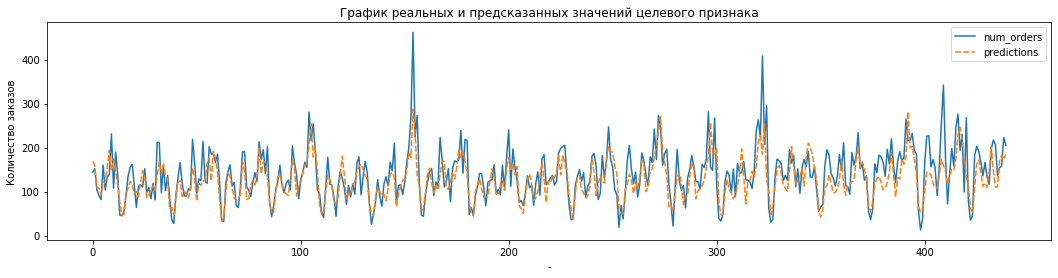

In [ ]:
# визуализация реальных и предсказанных значений целевого признака
df_visualization = y_test.reset_index()
df_visualization['predictions'] = preds_cb
plt.figure(figsize=(18, 4))
sns.lineplot(data=df_visualization)
plt.title(f'График реальных и предсказанных значений целевого признака')
plt.xlabel('-')
plt.ylabel('Количество заказов')

pass

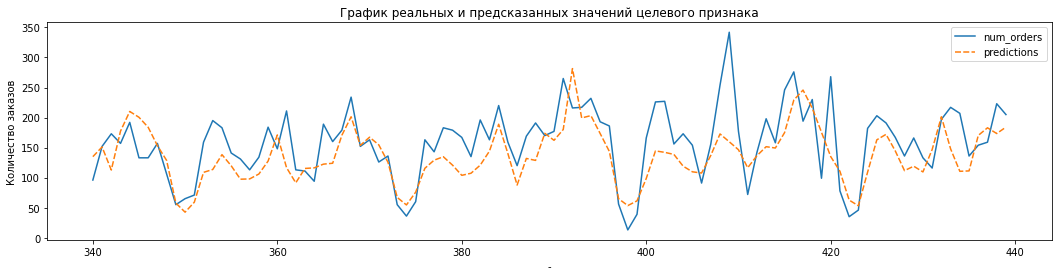

In [ ]:
# визуализация реальных и предсказанных значений целевого признака (поближе)
df_visualization = y_test.reset_index()
df_visualization['predictions'] = preds_cb
plt.figure(figsize=(18, 4))
sns.lineplot(data=df_visualization[340 : ])
plt.title(f'График реальных и предсказанных значений целевого признака')
plt.xlabel('-')
plt.ylabel('Количество заказов')

pass

In [ ]:
'''
Проверка модели на адекватность с помощью модели DummyRegressor
(стратегия - среднее значение обучающего набора)
'''
model_dr = DummyRegressor()
model_dr.fit(X_train, y_train)
preds_dr = model_dr.predict(X_test)
rmse_dr = mean_squared_error(y_test, preds_dr) ** 0.5
print('Метрика RMSE, шт.:', rmse_dr)

Метрика RMSE, шт.: 84.68768287118466


### Выводы

По графику истинных и предсказанных данных видно, что модель чаще недооценивает значения. Это нужно учесть при ее оптимизации<br>
Дополнительно была произведена проверка модели на адекватность. <br>
На тестовой выборке метрика лучшей модели соответствует требованию задачи (<48) и равна 40,47.

## Общие выводы

В настоящем проекте с помощью временных рядов было спрогнозировано количество заказов такси на следующий час.<br>
В данных присутствует шум, диапазон которого увеличивается ближе к концу временного ряда. Это влияет на регрессионные модели в худшую сторону.<br>
В качестве лучшей модели выбрана модель CatBoostRegressor: у нее лучшая метрика RMSE.<br>
По графику истинных и предсказанных данных видно, что модель чаще недооценивает значения. Это нужно учесть при ее оптимизации.